<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/community/eval_separation_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating `pyannote` pretrained speech separation pipelines

> Tutorial contributed by [Clément Pagés](https://github.com/clement-pages/)

In this tutorial, we will evaluate `pyannote` pretrained speech separation pipeline.

More precisely, we rely on the pretrained `ToTaToNet` separation model and pipeline, on the tasks of speaker diarization and automatic speech recognition (ASR).
More details about them are available in [this paper](https://www.isca-archive.org/odyssey_2024/kalda24_odyssey.pdf) which won the best student paper award at [Odyssey 2024](https://www.odyssey2024.org/).

```bibtex
@inproceedings{kalda24_odyssey,
  title     = {PixIT: Joint Training of Speaker Diarization and Speech Separation from Real-world Multi-speaker Recordings},
  author    = {Joonas Kalda and Clément Pagés and Ricard Marxer and Tanel Alumäe and Hervé Bredin},
  year      = {2024},
  booktitle = {The Speaker and Language Recognition Workshop (Odyssey 2024)},
  pages     = {115--122},
  doi       = {10.21437/odyssey.2024-17},
}
```

## Tutorial setup

### Google Colab Setup

If you are running this tutorial on Colab, execute the following commands in order to setup the environment.
These commands will install `pyannote.audio`, and other required dependencies.

In [ ]:
!pip install -qq speechbrain==0.5.16
!pip install -qq ipython==7.34.0
!pip install -qq ipywidgets openai-whisper whisperx==3.1.5 meeteval
!pip install -qq pyannote.audio[separation]==3.3.0

⚠ Make sure that you switch to a GPU runtime (Runtime > Change runtime type) then restart the runtime (Runtime > Restart session).
Otherwise, everything will be extremely slow.

### Non Google Colab setup

If you are not using Colab, this tutorial assumes that the following dependencies have been installed:
  - `pyannote.audio[separation]` for joint speech diarization and separation (as well as the evaluation of speaker diarization)
  - `openai-whisper` and `whisperx` for speech transcription
  - `meeteval` for the evaluation of speech transcription


### General setup (whatever the environment)

Update `ROOT_DIR` to the path where you want to download assets used in this tutorial.

In [2]:
import os

# update ROOT_DIR according to your setup
ROOT_DIR = "path/to/pyannote-audio"
ROOT_DIR = "/Users/hbredin/Development/pyannote/pyannote-audio"
os.environ["ASSET_DIR"] = ROOT_DIR + "/tutorials/assets/separation"

In [3]:
# create ASSET_DIR repertory
!mkdir -p ${ASSET_DIR}/sources

# Download audio files from AMI-SDM dataset used in this tutorial
!wget --continue -q -O ${ASSET_DIR}/mixture.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source0.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-0.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source1.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-1.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source2.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-2.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source3.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-3.wav

# Download rttm file
!wget --continue -q -O ${ASSET_DIR}/mixture.rttm https://raw.githubusercontent.com/pyannote/AMI-diarization-setup/main/only_words/rttms/test/ES2004a.rttm

In the following parts, we will work on a one-minute long chunk excerpt from a meeting involving 4 speakers.

In [4]:
# set visualization scope to this specific one-minute segment
from pyannote.core import notebook, Segment
segment = Segment(750, 810)
notebook.crop = segment

## Speaker diarization

First, we are going to evaluate the joint diarization/separation pipeline in terms of diarization performance by computing the [Diarization Error Rate](https://pyannote.github.io/pyannote-metrics/reference.html?highlight=diarization%20error%20rate#diarization) (DER) on the audio mixture.

We will rely on the implementation of this metric available inn [`pyannote.metrics`](https://github.com/pyannote/pyannote-metrics).

Let's load the example mixture and its corresponding reference (manual) annotation.

In [ ]:
from pyannote.database.util import load_rttm
from pyannote.audio.core.io import Audio

audio = Audio()

uri = "ES2004a" # original file name
file = os.environ["ASSET_DIR"] + "/mixture.wav"
mixture, sample_rate = audio.crop(file=file, segment=segment)

annotations = load_rttm(os.environ["ASSET_DIR"] + "/mixture.rttm")[uri]
annotations = annotations.crop(segment)

Let's take a look at the annotations, and listen the audio corresponding to the chunk.

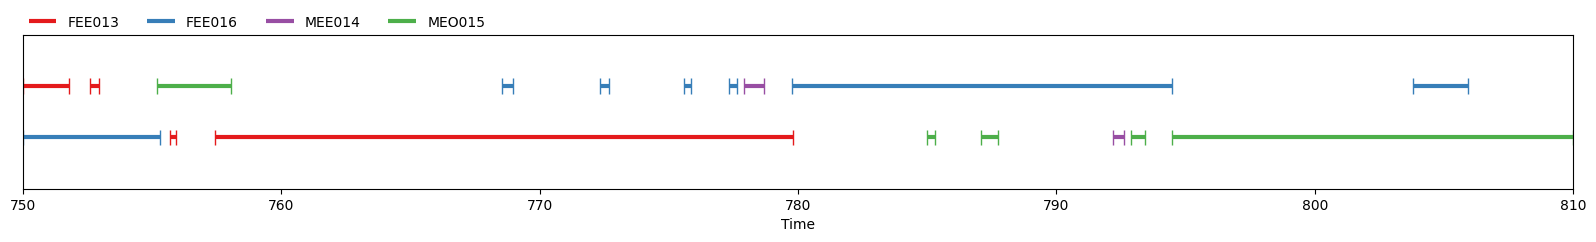

In [6]:
annotations

In [ ]:
from pyannote.audio.utils.preview import listen
listen(audio_file=file, segment=segment)

Now that we have loaded the mixture and the corresponding annotations, we load the pretrained joint diarization/separation pipeline.

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://huggingface.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those pipelines can perfectly be downloaded for later offline use: see the end of [this tutorial](https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/applying_a_pipeline.ipynb) to learn how to do that.

To load the pipeline used in this tutorial, you have to visit [hf.co/pyannote/speech-separation-ami-1.0](https://huggingface.co/pyannote/speech-separation-ami-1.0), accept the terms, visit [hf.co/pyannote/separation-ami-1.0](https://huggingface.co/pyannote/separation-ami-1.0) (used internally by the pipeline), and accept the terms. Then, if you have not already done so, create a Huggingface token by going [here](https://huggingface.co/settings/tokens), and log in using `notebook_login` below:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained(
    "pyannote/speech-separation-ami-1.0", use_auth_token=True)

# you can safely ignore that various warnings below.

In this tutorial, we use the set of hyper-parameters optimized for the diarization task.

In [ ]:
pipeline.instantiate(
    {
        "segmentation": {
            "min_duration_off": 0.0,
            "threshold": 0.5,
        },
        "clustering": {
            "method": "centroid",
            "threshold": 0.68,
            "min_cluster_size": 60,
        },
        "separation": {
            "leakage_removal": True,
            "asr_collar": 0.0,
        }
    }
)

In order to speed up processing, run the pipeline on a GPU device, if available.

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device=device)

The next step consists in applying the pipeline to get diarization prediction, and compare them to the annotation by computing DER.

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.audio.pipelines.utils.hook import ProgressHook

metric = DiarizationErrorRate()

# we use a ProgressHook, which will print progress for each step in the pipeline
with ProgressHook() as hook:
  # apply pipeline on the mixture file and get diarization prediction
  diarization, sources_hat = pipeline({"waveform": mixture, "sample_rate": sample_rate}, hook=hook)

Remember that we focused on the 1 minute sample starting at `t=750s`? The pipeline does not know about that so we need to shift the segments by that many seconds.

In [13]:
from pyannote.core import Annotation

shifted_diarization = Annotation(uri=uri)

for seg, track, label in diarization.itertracks(yield_label=True):
  shifted_segment = Segment(seg.start + 750., seg.end + 750.)
  shifted_diarization[shifted_segment, track] = label


We can then display the predicted speaker diarization:

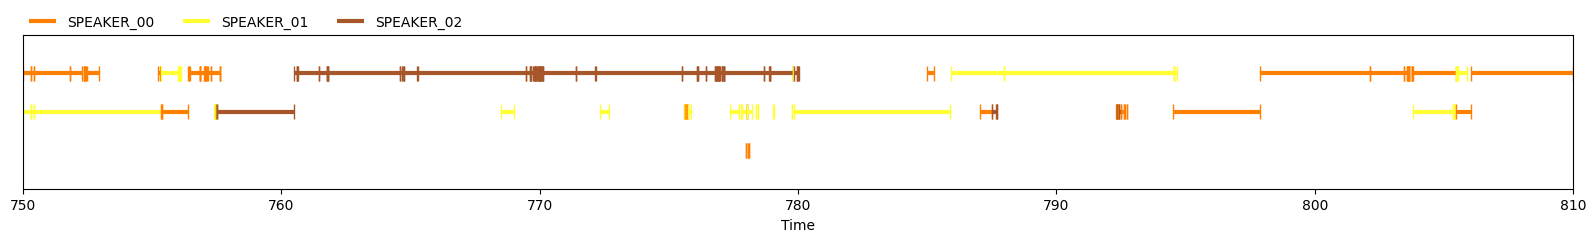

In [14]:
shifted_diarization

Finally, compute the DER and its components:

In [15]:
metric(annotations, shifted_diarization, detailed=True)

  warnings.warn(



{'missed detection': 2.9160000000003947,
 'false alarm': 1.9320000000000164,
 'correct': 63.19799999999998,
 'confusion': 3.205999999999676,
 'total': 69.32000000000005,
 'diarization error rate': 0.11618580496249396}

## Speech transcription of the separated source


We now switch to the evaluation of the speech separation part through the spectrum of its impact on automatic speech recognition.

Here, we apply [Whisper](https://github.com/openai/whisper) pretrained speech-to-text model to each separated source.
The final transcription is evaluated by comparison with the reference (manual) transcriptionusing [Concatenated minimum-Permutation Word Error Rate](https://arxiv.org/abs/2004.09249) (cpWER), available in the [MeetEval](https://github.com/fgnt/meeteval) toolkit.

We start by instantiating the pipeline with hyper-parameters optimized for the speech-to-text task.

In [ ]:
pipeline.instantiate(
    {
        "segmentation": {"min_duration_off": 0.0, "threshold": 0.82},
        "clustering": {
            "method": "centroid",
            "min_cluster_size": 15,
            "threshold": 0.68,
        },
        "separation": {
            "leakage_removal": True,
            "asr_collar": 0.32,
        }
    }
)

Reference transcription is loaded and normalized with Whisper built-in normalization function.

In [17]:
import whisperx
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

references = [
    "So simplification of symbols you could think of. Mm-hmm. Menu, alright. Uh uh Right, I was thinking on the same lines you, instead of having too many b buttons and make it complicated for the user, may h maybe have an L_C_D_ di display or something like that, like a mobile, yeah and with menus. And if it's s somewhat similar to what you have on mobile phone, people might find it easier to browse",
    "button or something like that. Yeah. Um. When they're when you've got the main things on the front of it and a section opens up or something to the other functions where you can do sound or options kind of recording, things like that inside it. 'Cause it doesn't make when you pick it up it doesn't make it really complicated to look at, it's obvious what you're doing, um.",
    "Mm. Yeah.",
    ". And symbols that you don't necessarily understand, symbols you're meant to understand that you don't. Oh yeah. Mm-hmm. Mm. Mm-hmm. Actually that just raises a point, I wonder what our design people think, but you know on a mobile phone, you can press a key and it gives you a menu, it's got a menu display, I wonder if incorporating that into the design of a remote control might be useful, so you've got a little L_C_D_ display. With menus, yeah, yeah.",
]

references_formatted = []
for i in range(len(references)):
    if references[i] != "":
        references_formatted.append(normalizer(references[i]))

references = references_formatted

Apply the pipeline on the mixture to get separated sources.

In [ ]:
from pyannote.audio.pipelines.utils.hook import ProgressHook

with ProgressHook() as hook:
  diarization, sources = pipeline({"waveform": mixture, "sample_rate": sample_rate}, hook=hook)

Listen to one of the separated source:

In [ ]:
from IPython.display import Audio, display

source_1 = sources[:, 1]
display(Audio(source_1, rate=sample_rate))

Get transcription for each predicted source by applying `Whisper`:

In [ ]:
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float32" # "float16"
modelx = whisperx.load_model("small.en", device=device, compute_type=compute_type)

def apply_whisperx(audio, sample_rate=16000):
    audio = np.float32(audio / np.max(np.abs(audio)))
    result = modelx.transcribe(audio, batch_size=16, language="en")
    output = result["segments"]  # after alignment
    text = ""
    for utterance in output:
        text = text + " " + utterance["text"]
    return normalizer(text)

predictions = []
for i in range(sources.data.shape[1]):
    print(f'Processing source #{i+1}...')
    text = apply_whisperx(sources.data[:, i])
    predictions.append(text)

# only consider 10 longest predictions to save computation time
predictions = sorted(predictions, key=len, reverse=True)[:10]

if len(predictions) < len(references):
    predictions = predictions + [""] * (len(references) - len(predictions))

# normalize prediction
for i in range(len(predictions)):
    predictions[i] = normalizer(predictions[i])

Finally, compute `cpWER` and display its component.

It is necessary to take into account all possible permutations, since the order of sources predicted by the pipeline does not necessarily correspond to the order of sources in the reference.

In [21]:
from itertools import permutations

from meeteval.wer.wer.cp import cp_word_error_rate

min_error_rate = 1.0
min_cpwer = None

all_permutations = list(permutations(predictions, len(references)))

# compute cpwer on each permutation and keep the best one
for permutation in all_permutations:
    cpwer = cp_word_error_rate(references, list(permutation))
    if cpwer.error_rate < min_error_rate:
        min_error_rate = cpwer.error_rate
        min_cpwer = cpwer


In [22]:
C = min_cpwer.length - min_cpwer.errors
S = min_cpwer.substitutions
D = min_cpwer.deletions
I = min_cpwer.insertions
deletion_rate = D / (C + S + D) * 100
insertion_rate = I / (C + S + D) * 100
substitution_rate = S / (C + S + D) * 100

print("cpWER breakdown")
print(f"Substitution rate: {substitution_rate:.1f}%")
print(f"Deletion rate: {deletion_rate:.1f}%")
print(f"Insertion rate: {insertion_rate:.1f}%")
print(f"Total WER: {min_cpwer.error_rate * 100:.1f}%")

cpWER breakdown
Substitution rate: 3.4%
Deletion rate: 12.9%
Insertion rate: 1.3%
Total WER: 17.4%


Great! We managed to evaluate the joint diarization/separation pipeline for both diarization and subsequent transcription tasks!

## Bonus: speaker separation

Here, we evaluate the joint model `ToTaToNet` in terms of separation capacities (applied on the first 5 seconds of the mixture).  
This model provides both diarization and separated sources.   
We rely on  [`asteroid`](https://github.com/asteroid-team/asteroid) for evaluation -- a generic audio source separation toolkit providing a bunch of metrics for this task.

We start by loading the clean sources used to generate the mixture (`mixture = source1 + ... + source4`).

In [ ]:
import numpy as np

chunk = Segment(0, 5)
sources = []
for i in range(3):
  file = os.environ["ASSET_DIR"] + f"/sources/source{i}.wav"
  source, _ = audio.crop(file=file, segment=chunk, duration=5.)
  sources.append(source.squeeze(0).numpy())
sources = np.array(sources)

sources.shape # (num_speakers, num_samples)

(3, 80000)

We apply `ToTaToNet` on the 5 seconds chunk and retrieve both diarization and separated sources.

In [ ]:
from pyannote.audio.core.model import Model

# apply totatonet on the first five seconds
totatonet = Model.from_pretrained("pyannote/separation-ami-1.0", use_auth_token=True)
totatonet.to(device)

cropped_mixture = mixture[:, :sample_rate * 5].unsqueeze(0)
diarization, sources_hat = totatonet(cropped_mixture.to(device))

sources_hat.shape # (batch_size, num_samples, num_sources)

Sources produced by the model can be in any order. Therefore, we compute the separation metrics on all possible permutations, and retain the permutation giving the best performance (here in terms of SI-SDR, but this could be any other metric proposed by `asteroid`).

In [ ]:
# get all possible permutations
sources_hat = sources_hat.squeeze(0).cpu().detach().numpy()
sources_hat = sources_hat.T

all_permutations = list(permutations(sources_hat, 3))

In [ ]:
# compute metrics on each permutation, and keep the best permutation in terms of SI-SDR

from asteroid.metrics import get_metrics
import numpy as np


best_si_sdr = -1000
metrics_dict = {}
cropped_mixture = cropped_mixture.squeeze().cpu().numpy()

for permutation in all_permutations:
    metrics = get_metrics(
        metrics_list="all",
        mix=cropped_mixture,
        clean=sources,
        estimate=np.array(permutation)
    )
    si_sdr = metrics["si_sdr"]
    if si_sdr > best_si_sdr:
        best_si_sdr = si_sdr
        metrics_dict = metrics

metrics_dict

{'input_si_sdr': -65.86242802937825,
 'input_sdr': -28.623883950224783,
 'input_sir': -4.125154507996655,
 'input_sar': -22.447442779085936,
 'input_stoi': -0.03292179880781989,
 'input_pesq': 1.0474077065785725,
 'si_sdr': -45.33342997233073,
 'sdr': -23.06402279776748,
 'sir': 2.0923609585372533,
 'sar': -20.51731126119207,
 'stoi': -0.03345884231432133,
 'pesq': 1.0672541459401448}

In [ ]:
print("SI SDR improvement = ", metrics_dict["si_sdr"] - metrics_dict["input_si_sdr"], "dB")

SI SDR improvement =  20.528998057047524 dB
